<center><h1>Inteligencia Artificial</header1></center>

Presentado por: <br>
- Anthony Mauricio Goyes Díaz  <br>
- Bryan Alfredo Solórzano Montero <br>

Fecha: 13/08/2022

# Importación de librerias necesarias

In [172]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.callbacks import EarlyStopping

## Cargar y exploración del Dataset

In [50]:
'''Se establece la ruta general de espacio de trabajo'''
os.chdir('C:/Users/Personal/IA/Laboratorio1U3')

In [51]:
semilla_aleatoria = 9
'''Se establece la ruta de las imágenes'''
ruta_imagenes = "./Estudiantes_datos_fondoEliminado"
'''Se muestra los directorios (clases) del dataset'''
nombre_clases = os.listdir(ruta_imagenes)
'''Se ordenan en orden alfabético (AZ - az)'''
nombre_clases.sort()
'''Se muestran las clases del dataset'''
print("Lista de clases = ",nombre_clases,"\nNo. de clases = ", len(nombre_clases))

Lista de clases =  ['GoyesAnthony', 'HerediaGenesis', 'SolorzanoBryan', 'WilmerSolano', 'ZambranoJhon'] 
No. de clases =  5


In [52]:
def cargar_imagenes_etiquetas(clases):
    imagenes = []
    etiquetas = []
    for iterador, clase in enumerate(clases):
        for image_name in os.listdir(ruta_imagenes+"/"+clase):
            imagen = cv2.imread(ruta_imagenes+"/"+clase+"/"+image_name)
            imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
            
            img_array = Image.fromarray(imagen, 'RGB')
            
            imagenes.append(np.array(img_array))
            
            etiquetas.append(iterador)
    return imagenes, etiquetas

imagenes, etiquetas = cargar_imagenes_etiquetas(nombre_clases)
print("No. de imagenes cargadas = ",len(imagenes),"\nNo. de etiquetas cargadas = ",len(etiquetas))
print(type(imagenes),type(etiquetas))

No. de imagenes cargadas =  150 
No. de etiquetas cargadas =  150
<class 'list'> <class 'list'>


In [53]:
imagenes = np.array(imagenes)
etiquetas = np.array(etiquetas)

print("Dimensión de la imagen = ",imagenes.shape,"\nDimensión de la etiqueta = ",etiquetas.shape)
print(type(imagenes),type(etiquetas))

Dimensión de la imagen =  (150, 192, 192, 3) 
Dimensión de la etiqueta =  (150,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


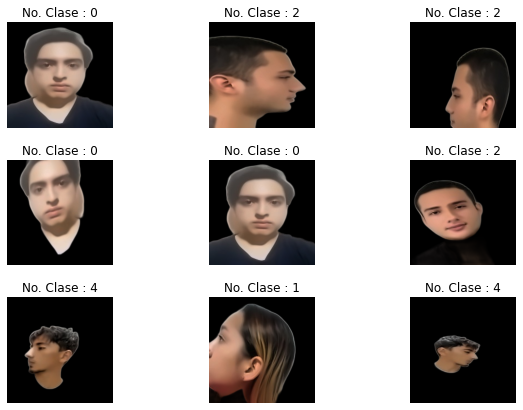

In [61]:
def mostrar_imagenes_aleatorias(imagenes, etiquetas):
    plt.figure(1 , figsize = (10 , 7))
    n = 0 
    for iterador in range(9):
        n += 1 
        numero_aleatario = np.random.randint(0 , imagenes.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(imagenes[numero_aleatario[0]])
        
        plt.title('No. Clase : {}'.format(etiquetas[numero_aleatario[0]]))
        plt.axis('off')
        
    plt.show()
    
mostrar_imagenes_aleatorias(imagenes, etiquetas)

## Prepare data for training the CNN modelo

In [55]:
'''Barajando los datos'''
'''Primer paso'''
numero_aleatorio = np.arange(imagenes.shape[0])
print("Valores antes de barajear = ",numero_aleatorio)

'''Barajando todos los valores igualmente espaciados en la lista almacenada aleatoriamente'''
np.random.seed(semilla_aleatoria)
np.random.shuffle(numero_aleatorio)
print("\nValores después de barajear = ",numero_aleatorio)

Valores antes de barajear =  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149]

Valores después de barajear =  [135  90 145 147  60  37  26   3  75   9  25  73  98  94  39  81  31  55
 101  47  28  27 111  20 118  89  43 144   8 137 112 138  23  67  79  82
  76  45 109   7  17 100  86  44 103  68   6  69  35 130  70  51  10  53
 133 136 110 140  80  21 134  38   2  84 116  11  57  78 122  96  97  36
  32 148  88  14 107  83 106  95  48 

In [56]:
'''Segundo paso'''
'''Barajendo las imágenes y los datos de las etiquetas correspondientes en las dos listas'''
imagenes = imagenes[numero_aleatorio]
etiquetas = etiquetas[numero_aleatorio]

print("Dimensiones de la imagen después de barajear = ",imagenes.shape,"\nDimensiones de " +
    "las etiquetas después de barajear = ",etiquetas.shape)

Dimensiones de la imagen después de barajear =  (150, 192, 192, 3) 
Dimensiones de las etiquetas después de barajear =  (150,)


In [57]:
imagenes = imagenes.astype(np.float32)
etiquetas = etiquetas.astype(np.int32)
imagenes = imagenes/255
print("Dimensión de las imágenes después de normalizar= ",imagenes.shape)

Dimensión de las imágenes después de normalizar=  (150, 192, 192, 3)


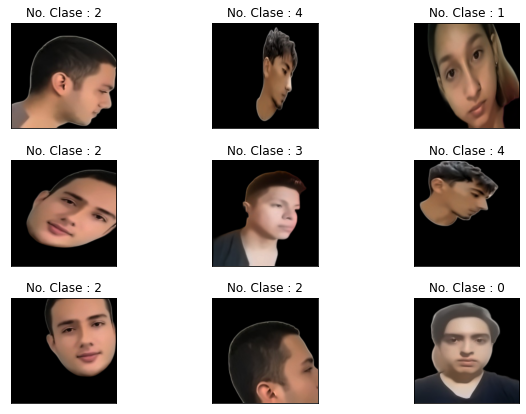

In [58]:
mostrar_imagenes_aleatorias(imagenes, etiquetas)

In [77]:
train_fotos, test_fotos, train_etiquetas, test_etiquetas = train_test_split(imagenes, etiquetas,
                                                                 test_size = 0.2, random_state = semilla_aleatoria)
print("Dimensión train_fotos = ",train_fotos.shape)
print("Dimensión train_etiquetas= ",train_etiquetas.shape)
print("\nDimensión test_fotos = ",test_fotos.shape)
print("Dimensión test_etiquetas = ",test_etiquetas.shape)

Dimensión train_fotos =  (120, 192, 192, 3)
Dimensión train_etiquetas=  (120,)

Dimensión test_fotos =  (30, 192, 192, 3)
Dimensión test_etiquetas =  (30,)


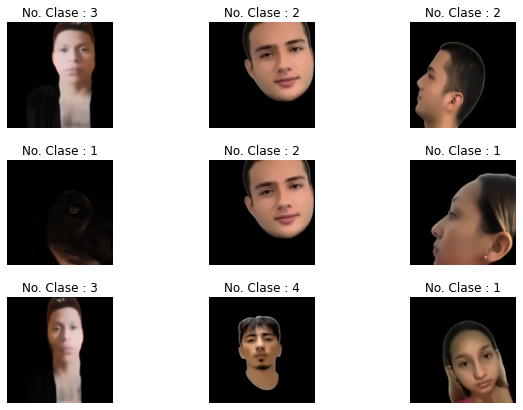

In [78]:
mostrar_imagenes_aleatorias(train_fotos, train_etiquetas)

# modeloo AlexNet

## Primer experimento

In [80]:
## Se cambia el tamaño de las fotos
train_fotos = tf.image.resize(train_fotos, (227, 227))
test_fotos = tf.image.resize(test_fotos, (227, 227))

In [109]:
modelo = Sequential()
#1 conv layer
modelo.add(Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),padding="valid",activation="relu",input_shape=(227,227,3)))
#1 max pool layer
modelo.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
modelo.add(BatchNormalization())
#2 conv layer
modelo.add(Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),padding="valid",activation="relu"))
#2 max pool layer
modelo.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
modelo.add(BatchNormalization())
#3 conv layer
modelo.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))
#4 conv layer
modelo.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))
#5 conv layer
modelo.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))
#3 max pool layer
modelo.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
modelo.add(BatchNormalization())
modelo.add(Flatten())
#1 dense layer
modelo.add(Dense(4096,input_shape=(227,227,3),activation="relu"))
modelo.add(Dropout(0.4))
modelo.add(BatchNormalization())
#2 dense layer
modelo.add(Dense(4096,activation="relu"))
modelo.add(Dropout(0.4))
modelo.add(BatchNormalization())
#3 dense layer
modelo.add(Dense(1000,activation="relu"))
modelo.add(Dropout(0.4))
modelo.add(BatchNormalization())
#output layer
modelo.add(Dense(20,activation="softmax"))
modelo.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 27, 27, 96)       0         
 g2D)                                                            
                                                                 
 batch_normalization_22 (Bat  (None, 27, 27, 96)       384       
 chNormalization)                                                
                                                                 
 conv2d_42 (Conv2D)          (None, 23, 23, 256)       614656    
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 11, 11, 256)      0         
 g2D)                                                            
                                                      

In [82]:
'''Se compila el modelo'''
modelo.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

### Entrenar el modelo

In [93]:
modelo.fit(train_fotos, train_etiquetas, epochs=100)

Epoch 1/100
4/4 [==============================] - 12s 3s/step - loss: 0.7420 - accuracy: 0.7583
Epoch 2/100
4/4 [==============================] - 14s 4s/step - loss: 0.6780 - accuracy: 0.7583
Epoch 3/100
4/4 [==============================] - 17s 4s/step - loss: 0.4260 - accuracy: 0.8667
Epoch 4/100
4/4 [==============================] - 14s 3s/step - loss: 0.5174 - accuracy: 0.8000
Epoch 5/100
4/4 [==============================] - 12s 3s/step - loss: 0.4249 - accuracy: 0.8667
Epoch 6/100
4/4 [==============================] - 13s 3s/step - loss: 0.5229 - accuracy: 0.8167
Epoch 7/100
4/4 [==============================] - 15s 4s/step - loss: 0.2786 - accuracy: 0.8667
Epoch 8/100
4/4 [==============================] - 12s 3s/step - loss: 0.3111 - accuracy: 0.8750
Epoch 9/100
4/4 [==============================] - 12s 3s/step - loss: 0.3831 - accuracy: 0.8833
Epoch 10/100
4/4 [==============================] - 13s 3s/step - loss: 0.6942 - accuracy: 0.7750
Epoch 11/100
4/4 [===========

In [94]:
perdida, exactitud_primero = modelo.evaluate(test_fotos, test_etiquetas)

print(perdida,exactitud_primero)

1/1 [==============================] - 7s 7s/step - loss: 1.6986 - accuracy: 0.6667
1.698626160621643 0.6666666865348816


### Predecir valores con el modelo entrenado

In [95]:
pred = modelo.predict(test_fotos)
pred.shape

1/1 [==============================] - 1s 727ms/step


(30, 20)

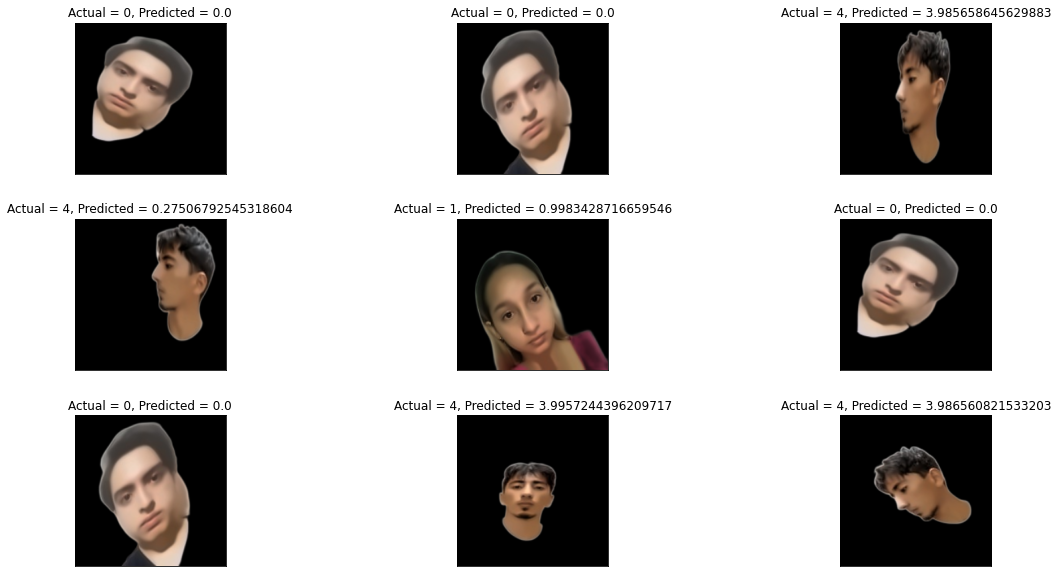

In [98]:
plt.figure(1 , figsize = (19 , 10))
n = 0 

for i in range(9):
    n += 1 
    r = np.random.randint( 0, test_fotos.shape[0], 1)
    
    plt.subplot(3, 3, n)
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    plt.imshow(test_fotos[r[0]])
    plt.title('Actual = {}, Predicted = {}'.format(test_etiquetas[r[0]] ,
             test_etiquetas[r[0]]*pred[r[0]][test_etiquetas[r[0]]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()

## Segundo experimento

In [124]:
train_fotos, test_fotos, train_etiquetas, test_etiquetas = train_test_split(imagenes, etiquetas,
                                                                 test_size = 0.2, random_state = semilla_aleatoria)
print("Dimensión train_fotos = ",train_fotos.shape)
print("Dimensión train_etiquetas= ",train_etiquetas.shape)
print("\nDimensión test_fotos = ",test_fotos.shape)
print("Dimensión test_etiquetas = ",test_etiquetas.shape)

Dimensión train_fotos =  (120, 192, 192, 3)
Dimensión train_etiquetas=  (120,)

Dimensión test_fotos =  (30, 192, 192, 3)
Dimensión test_etiquetas =  (30,)


In [125]:
modelo2 = Sequential()
#1 conv layer
modelo2.add(Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),activation="relu",input_shape=(192,192,3)))
#1 max pool layer
modelo2.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
modelo2.add(BatchNormalization())
#2 conv layer
modelo2.add(Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),padding="same",activation="relu"))
#2 max pool layer
modelo2.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
modelo2.add(BatchNormalization())
#3 conv layer
modelo2.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="same",activation="relu"))
#4 conv layer
modelo2.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="same",activation="relu"))
#5 conv layer
modelo2.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding="same",activation="relu"))
#3 max pool layer
modelo2.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
modelo2.add(BatchNormalization())
modelo2.add(Flatten())
#1 dense layer
modelo2.add(Dense(4096,input_shape=(192,192,3),activation="relu"))
modelo2.add(Dropout(0.2))
modelo2.add(BatchNormalization())
#output layer
modelo2.add(Dense(20,activation="softmax"))
modelo2.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_106 (Conv2D)         (None, 46, 46, 96)        34944     
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 22, 22, 96)       0         
 g2D)                                                            
                                                                 
 batch_normalization_64 (Bat  (None, 22, 22, 96)       384       
 chNormalization)                                                
                                                                 
 conv2d_107 (Conv2D)         (None, 22, 22, 256)       614656    
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 10, 10, 256)      0         
 g2D)                                                            
                                                     

In [126]:
'''Se compila el modelo'''
modelo2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [129]:
modelo2.fit(train_fotos, train_etiquetas, epochs=100)

Epoch 1/100
4/4 [==============================] - 27s 3s/step - loss: 6.9580 - accuracy: 0.2167
Epoch 2/100
4/4 [==============================] - 11s 3s/step - loss: 3.7762 - accuracy: 0.5167
Epoch 3/100
4/4 [==============================] - 10s 3s/step - loss: 1.4198 - accuracy: 0.6833
Epoch 4/100
4/4 [==============================] - 11s 3s/step - loss: 0.9275 - accuracy: 0.6667
Epoch 5/100
4/4 [==============================] - 10s 2s/step - loss: 0.7204 - accuracy: 0.7333
Epoch 6/100
4/4 [==============================] - 10s 3s/step - loss: 0.4518 - accuracy: 0.8500
Epoch 7/100
4/4 [==============================] - 12s 3s/step - loss: 0.4273 - accuracy: 0.8333
Epoch 8/100
4/4 [==============================] - 10s 2s/step - loss: 0.3905 - accuracy: 0.8917
Epoch 9/100
4/4 [==============================] - 10s 2s/step - loss: 0.3222 - accuracy: 0.9000
Epoch 10/100
4/4 [==============================] - 10s 2s/step - loss: 0.2070 - accuracy: 0.9417
Epoch 11/100
4/4 [===========

In [131]:
perdida, exactitud_segundo = modelo2.evaluate(test_fotos, test_etiquetas)

print(perdida,exactitud_segundo)

1/1 [==============================] - 2s 2s/step - loss: 3.4089 - accuracy: 0.5333
3.408914089202881 0.5333333611488342


### Predecir valores con el modelo entrenado

In [132]:
pred_segunda = modelo2.predict(test_fotos)
pred_segunda.shape

1/1 [==============================] - 1s 1s/step


(30, 20)

3.408914089202881 0.5333333611488342


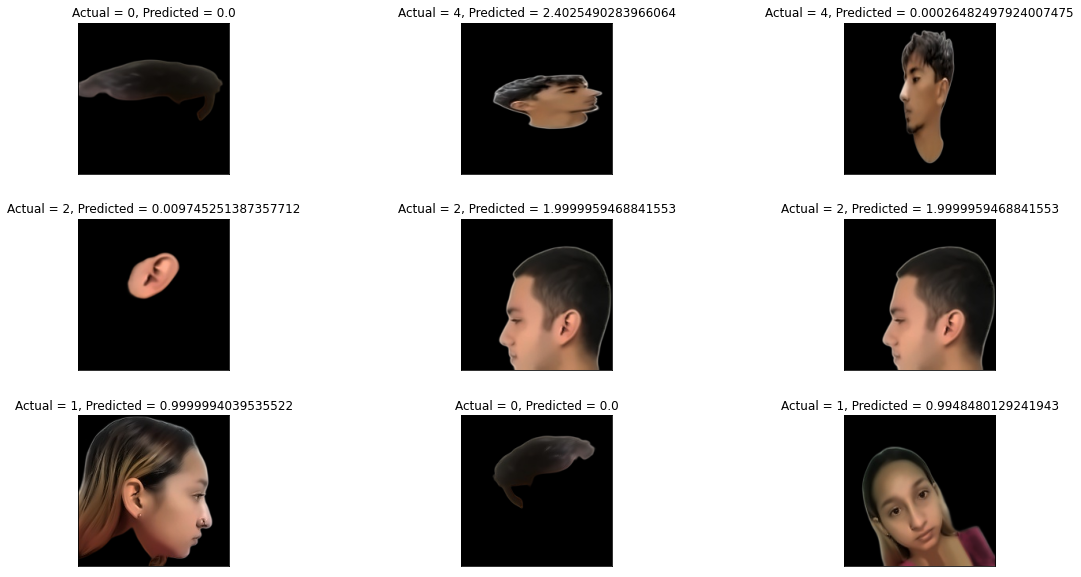

In [133]:
print(perdida,exactitud_segundo)

plt.figure(1 , figsize = (19 , 10))
n = 0 

for i in range(9):
    n += 1 
    r = np.random.randint( 0, test_fotos.shape[0], 1)
    
    plt.subplot(3, 3, n)
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    plt.imshow(test_fotos[r[0]])
    plt.title('Actual = {}, Predicted = {}'.format(test_etiquetas[r[0]] ,
             test_etiquetas[r[0]]*pred_segunda[r[0]][test_etiquetas[r[0]]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()

## Tercer experimento

In [146]:
train_fotos, test_fotos, train_etiquetas, test_etiquetas = train_test_split(imagenes, etiquetas,
                                                                 test_size = 0.2, random_state = semilla_aleatoria)
print("Dimensión train_fotos = ",train_fotos.shape)
print("Dimensión train_etiquetas= ",train_etiquetas.shape)
print("\nDimensión test_fotos = ",test_fotos.shape)
print("Dimensión test_etiquetas = ",test_etiquetas.shape)

Dimensión train_fotos =  (120, 192, 192, 3)
Dimensión train_etiquetas=  (120,)

Dimensión test_fotos =  (30, 192, 192, 3)
Dimensión test_etiquetas =  (30,)


In [147]:
## Se cambia el tamaño de las fotos
train_fotos = tf.image.resize(train_fotos, (227, 227))
test_fotos = tf.image.resize(test_fotos, (227, 227))

In [156]:
modelo3 = Sequential()
#1 conv layer
modelo3.add(Conv2D(filters=96,kernel_size=(11),strides=(4),padding="valid",activation="relu",input_shape=(227,227,3))) #padding -> 227x227
#1 max pool layer
modelo3.add(MaxPooling2D(pool_size=(3),strides=(2)))
#2 conv layer
modelo3.add(Conv2D(filters=256,kernel_size=(5),strides=(1),padding="valid",activation="relu")) #padding -> 55x55
#2 max pool layer
modelo3.add(MaxPooling2D(pool_size=(3),strides=(2)))
#3 conv layer
modelo3.add(Conv2D(filters=384,kernel_size=(3),strides=(1),padding="valid",activation="relu")) #padding -> 27x27
#4 conv layer
modelo3.add(Conv2D(filters=384,kernel_size=(3),strides=(1),padding="valid",activation="relu")) #padding -> 13x13
#5 conv layer
modelo3.add(Conv2D(filters=256,kernel_size=(3),strides=(1),padding="valid",activation="relu")) #padding -> 13x13
#3 max pool layer
modelo3.add(MaxPooling2D(pool_size=(3),strides=(2)))
modelo3.add(Flatten())
#1 dense layer
modelo3.add(Dense(4096,input_shape=(227*227*3,),activation="relu"))
modelo3.add(Dropout(0.4))
#2 dense layer
modelo3.add(Dense(4096,activation="relu"))
modelo3.add(Dropout(0.4))
#output layer
modelo3.add(Dense(1000,activation="softmax"))
modelo3.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_132 (Conv2D)         (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d_81 (MaxPoolin  (None, 27, 27, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_133 (Conv2D)         (None, 23, 23, 256)       614656    
                                                                 
 max_pooling2d_82 (MaxPoolin  (None, 11, 11, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_134 (Conv2D)         (None, 9, 9, 384)         885120    
                                                                 
 conv2d_135 (Conv2D)         (None, 7, 7, 384)       

In [159]:
'''Se compila el modelo'''
modelo3.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [160]:
modelo3.fit(train_fotos, train_etiquetas, epochs=100)

Epoch 1/100
4/4 [==============================] - 80s 3s/step - loss: 5.4173 - accuracy: 0.1000
Epoch 2/100
4/4 [==============================] - 9s 2s/step - loss: 4.0991 - accuracy: 0.2000
Epoch 3/100
4/4 [==============================] - 8s 2s/step - loss: 2.3407 - accuracy: 0.2417
Epoch 4/100
4/4 [==============================] - 8s 2s/step - loss: 1.8839 - accuracy: 0.1917
Epoch 5/100
4/4 [==============================] - 9s 2s/step - loss: 1.7247 - accuracy: 0.1750
Epoch 6/100
4/4 [==============================] - 8s 2s/step - loss: 1.7111 - accuracy: 0.1667
Epoch 7/100
4/4 [==============================] - 8s 2s/step - loss: 1.6725 - accuracy: 0.2167
Epoch 8/100
4/4 [==============================] - 8s 2s/step - loss: 1.6358 - accuracy: 0.2583
Epoch 9/100
4/4 [==============================] - 9s 2s/step - loss: 1.5813 - accuracy: 0.2417
Epoch 10/100
4/4 [==============================] - 8s 2s/step - loss: 1.6516 - accuracy: 0.2250
Epoch 11/100
4/4 [====================

In [164]:
perdida, exactitud_tercero = modelo3.evaluate(test_fotos, test_etiquetas)

print(perdida,exactitud_tercero)

1/1 [==============================] - 1s 659ms/step - loss: 0.4331 - accuracy: 0.8000
0.43311867117881775 0.800000011920929


### Predecir valores con el modelo entrenado

In [165]:
pred_tercero = modelo3.predict(test_fotos)
pred_tercero.shape

1/1 [==============================] - 0s 487ms/step


(30, 1000)

0.43311867117881775 0.800000011920929


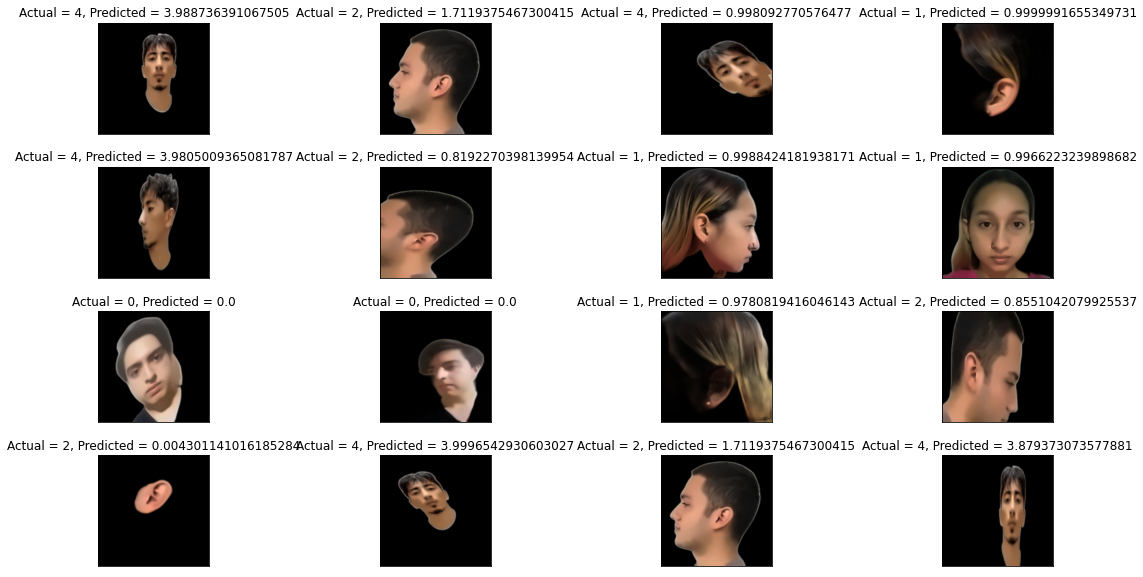

In [169]:
print(perdida,exactitud_tercero)

plt.figure(1 , figsize = (19 , 10))
n = 0 

for i in range(9):
    n += 1 
    r = np.random.randint( 0, test_fotos.shape[0], 1)
    
    plt.subplot(3, 3, n)
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    plt.imshow(test_fotos[r[0]])
    plt.title('Actual = {}, Predicted = {}'.format(test_etiquetas[r[0]] ,
             test_etiquetas[r[0]]*pred_tercero[r[0]][test_etiquetas[r[0]]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()

## Cuarto experimento

In [170]:
train_fotos, test_fotos, train_etiquetas, test_etiquetas = train_test_split(imagenes, etiquetas,
                                                                 test_size = 0.2, random_state = semilla_aleatoria)
print("Dimensión train_fotos = ",train_fotos.shape)
print("Dimensión train_etiquetas= ",train_etiquetas.shape)
print("\nDimensión test_fotos = ",test_fotos.shape)
print("Dimensión test_etiquetas = ",test_etiquetas.shape)

Dimensión train_fotos =  (120, 192, 192, 3)
Dimensión train_etiquetas=  (120,)

Dimensión test_fotos =  (30, 192, 192, 3)
Dimensión test_etiquetas =  (30,)


In [171]:
## Se cambia el tamaño de las fotos
train_fotos = tf.image.resize(train_fotos, (227, 227))
test_fotos = tf.image.resize(test_fotos, (227, 227))

In [179]:
tamanio_imagen = len(imagenes)

In [180]:
modelo4 = Sequential()
#1 conv layer
modelo4.add(Conv2D(filters=96,kernel_size=(11),strides=(4),padding="valid",activation="relu",input_shape=(227,227,3))) #padding -> 227x227
# Normalización por lotes antes de pasarla a la siguiente capa
modelo4.add(BatchNormalization())
#1 max pool layer
modelo4.add(MaxPooling2D(pool_size=(3),strides=(2)))
#2 conv layer
modelo4.add(Conv2D(filters=256,kernel_size=(5),strides=(1),padding="same",activation="relu")) #padding -> 55x55
modelo4.add(BatchNormalization())
#2 max pool layer
modelo4.add(MaxPooling2D(pool_size=(3),strides=(2)))
#3 conv layer
modelo4.add(Conv2D(filters=384,kernel_size=(3),strides=(1),padding="same",activation="relu")) #padding -> 27x27
# Normalización por lotes antes de pasarla a la siguiente capa
modelo4.add(BatchNormalization())
modelo4.add(Dropout(0.5))
# 4th Convolutional Layer
modelo4.add(Conv2D(filters = 384, kernel_size = (3), strides = (1), padding = 'same', activation="relu"))
# Batch Normalisation
modelo4.add(BatchNormalization())
# Dropout
modelo4.add(Dropout(0.5))
# 5th Convolutional Layer
modelo4.add(Conv2D(filters = 256, kernel_size = (3), strides = (1), padding = 'same', activation="relu"))
# Batch Normalisation
modelo4.add(BatchNormalization())
# Pooling Layer
modelo4.add(MaxPooling2D(pool_size = (3), strides = (2), padding = 'valid'))
# Dropout
modelo4.add(Dropout(0.5))
# Passing it to a dense layer
modelo4.add(Flatten())
# 1st Dense Layer
modelo4.add(Dense(4096, input_shape = (227*227*3,), activation="relu"))
# Add Dropout to prevent overfitting
modelo4.add(Dropout(0.25))
# Batch Normalisation
modelo4.add(BatchNormalization())
# 2nd Dense Layer
modelo4.add(Dense((4096), activation="relu"))
# Add Dropout
modelo4.add(Dropout(0.5))
# Batch Normalisation
modelo4.add(BatchNormalization())
# 3rd Dense Layer
modelo4.add(Dense((1000), activation="relu"))
# Add Dropout
modelo4.add(Dropout(0.5))
# Batch Normalisation
modelo4.add(BatchNormalization())
# Output Layer
modelo4.add(Dense(tamanio_imagen))
# Get the model summary.
modelo4.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_159 (Conv2D)         (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization_99 (Bat  (None, 55, 55, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_97 (MaxPoolin  (None, 27, 27, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_160 (Conv2D)         (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_100 (Ba  (None, 27, 27, 256)      1024      
 tchNormalization)                                               
                                                     

In [182]:
'''Se compila el modelo'''
modelo4.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

c:\Users\Personal\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [183]:
modelo4.fit(train_fotos, train_etiquetas, epochs=100)

Epoch 1/100
4/4 [==============================] - 134s 8s/step - loss: 12.1428 - accuracy: 0.0167
Epoch 2/100
4/4 [==============================] - 18s 4s/step - loss: 12.0482 - accuracy: 0.0083
Epoch 3/100
4/4 [==============================] - 18s 4s/step - loss: 11.9522 - accuracy: 0.0083
Epoch 4/100
4/4 [==============================] - 17s 4s/step - loss: 11.0528 - accuracy: 0.0083
Epoch 5/100
4/4 [==============================] - 17s 4s/step - loss: 10.8501 - accuracy: 0.0083
Epoch 6/100
4/4 [==============================] - 17s 4s/step - loss: 10.0610 - accuracy: 0.0000e+00
Epoch 7/100
4/4 [==============================] - 16s 4s/step - loss: 9.6557 - accuracy: 0.0000e+00
Epoch 8/100
4/4 [==============================] - 16s 4s/step - loss: 8.5346 - accuracy: 0.0000e+00
Epoch 9/100
4/4 [==============================] - 16s 4s/step - loss: 8.3255 - accuracy: 0.0000e+00
Epoch 10/100
4/4 [==============================] - 16s 4s/step - loss: 8.0495 - accuracy: 0.0167
Epoch 

In [ ]:
perdida, exactitud_tercero = modelo3.evaluate(test_fotos, test_etiquetas)

print(perdida,exactitud_tercero)

1/1 [==============================] - 1s 659ms/step - loss: 0.4331 - accuracy: 0.8000
0.43311867117881775 0.800000011920929


### Predecir valores con el modelo entrenado

In [ ]:
pred_tercero = modelo3.predict(test_fotos)
pred_tercero.shape

1/1 [==============================] - 0s 487ms/step


(30, 1000)

0.43311867117881775 0.800000011920929


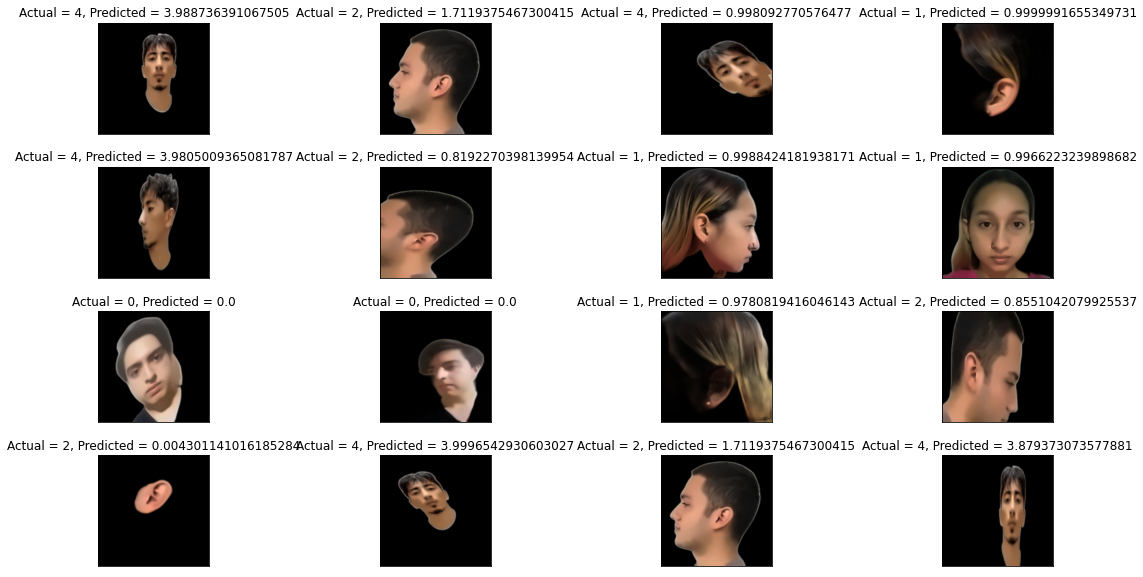

In [ ]:
print(perdida,exactitud_tercero)

plt.figure(1 , figsize = (19 , 10))
n = 0 

for i in range(9):
    n += 1 
    r = np.random.randint( 0, test_fotos.shape[0], 1)
    
    plt.subplot(3, 3, n)
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    plt.imshow(test_fotos[r[0]])
    plt.title('Actual = {}, Predicted = {}'.format(test_etiquetas[r[0]] ,
             test_etiquetas[r[0]]*pred_tercero[r[0]][test_etiquetas[r[0]]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()